In [1]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels.dof2 as dof2
import FwtModels.AeroModels as ams

In [2]:
p = dof2.FwtParameters.Default2DoF() # parameter container

p.GetTuple(ignore=[p.V,p.alpha_r])

(m, l, s, c, k, g, Lambda, rho, a_t)

### Define the problem

In [3]:
# want to create a model with some fixed parameters

# create the variables
p = dof2.FwtParameters.Default2DoF() # parameter container

mass_ratio = 4                    # mass ratio between wing and FWT
p.m_w = dof2.FwtVariable(4,'m_w')   # mass of inner wing
wing_freq = 2                       # freq of inner wing

# set values for independent symbols
p.s.value = 1
p.c.value = 0.15
p.g.value = 9.81
p.rho.value = 1.225
p.a_t.value = 2 * np.pi
p.alpha_r.value = np.deg2rad(5)
p.Lambda.value = np.deg2rad(-10)

# set expression for dependent symbols
p.k = (sym.Integer(wing_freq)*2*sym.pi)**2*(p.m_w+p.m_w/sym.Float(mass_ratio))
p.m = p.m_w/sym.Integer(mass_ratio)
p.I_xx = sym.Rational(1,12)*p.m*p.s**2*1
p.l = p.s*sym.Rational(2,4)

# potential Energy
half = sym.Rational(1,2)
U = p.m*p.g*(-p.l*sym.cos(p.q[0])) + half*p.k*(p.q[1])**2

# Create Point masses

# Transform for the mass
wing_frame = symt.HomogenousTransform().Translate(0,0,p.q[1])
fwt_frame = wing_frame.R_x(-sym.pi*sym.Rational(1,2)+p.q[0])
fwt_com_frame = fwt_frame.Translate(0,p.l,0)
rot = sym.Matrix([-sym.pi*sym.Rational(1,2)+p.q[0],0,0])


mw = dof2.RigidElement.PointMass(wing_frame,sym.Matrix([0,0,0]),p.m_w)


M_fwt = dof2.MassMatrix(p.m,I_xx = p.I_xx)

m = dof2.RigidElement(fwt_com_frame,rot,M_fwt)


# Aero Forces
AeroForces = ams.SimpleAeroModel(p,fwt_frame,at_mode=1)
me.mechanics_printing()


sm = dof2.SymbolicModel(U,[mw,m],p,ExtForces = AeroForces)

### Determine the fixed points of this system

In [4]:
# create data for the cruise angle for 3 different root AoA
thetas = np.linspace(0,np.pi,361)
aoa = [0,2.5,5,7.5,10]
df = pd.DataFrame()
TestConditions = pd.DataFrame()
funcs=[]

TestConditions['theta'] = np.linspace(0,np.pi,361)
for i in aoa:
    mdf = TestConditions.copy()
    mdf['alpha'] = i
    p.alpha_r.value = np.deg2rad(i)
    cruiseV = sm.CruiseAngleEqn(p,AeroForces)
    funcs.append(cruiseV)
    V,q1s = cruiseV(thetas)
    mdf['V'] = V
    mdf['q1_stat'] = q1s
    df = df.append(mdf, sort=False)

<string>:2: RuntimeWarning: invalid value encountered in sqrt
<string>:2: RuntimeWarning: invalid value encountered in sqrt
<string>:2: RuntimeWarning: invalid value encountered in sqrt
<string>:2: RuntimeWarning: invalid value encountered in sqrt
<string>:2: RuntimeWarning: invalid value encountered in sqrt


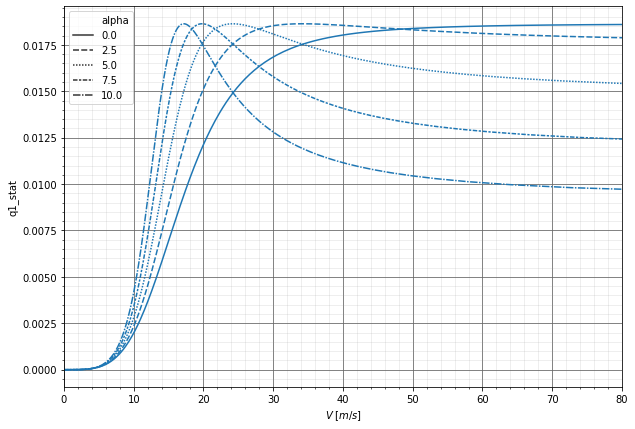

In [6]:
# plot the data
fig, axes = plt.subplots(1,1,figsize=(10,7))
df[r'$\theta [Deg]$']= np.rad2deg(df['theta'])
df[r'$V\; [m/s]$']= df['V']
sns.lineplot(data=df,y=r'q1_stat',x=r'$V\; [m/s]$',style='alpha',ax=axes)
axes.set(xlim=(0,80))
axes.grid(b=True, which='major', color='#666666', linestyle='-')
axes.minorticks_on()
axes.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

In [14]:
# get the velocity where thecruise angle is pi/2 (parallel)
df[df['theta']==np.pi/2]

,theta,alpha,V,q1_stat,$\theta [Deg]$,$V\; [m/s]$
180,1.570796,0.0,2.189682e+09,0.018637,90.0,2.189682e+09
180,1.570796,2.5,3.419287e+01,0.018637,90.0,3.419287e+01
180,1.570796,5.0,2.420094e+01,0.018637,90.0,2.420094e+01
180,1.570796,7.5,1.979103e+01,0.018637,90.0,1.979103e+01
180,1.570796,10.0,1.717688e+01,0.018637,90.0,1.717688e+01


### Linearise the system about some fixed points

In [15]:
# create complete EoM

func = dof2.LinearEoM_func(sm,p,AeroForces,ignore=[p.V,p.alpha_r])
#EoM = sm.X.subs({sm.F[0]:AeroForces.Q[0],sm.F[1]:AeroForces.Q[1]})

# sub all in but velocity
#tup = p.GetTuple(ignore=['V','alpha_r'])
#eqs = sym.simplify(EoM.subs({v:v.value for v in tup}))

#calculate the jacobian
#jac = eqs.jacobian(p.x)

# function to linearise jacobian
#lp = sym.Matrix(sym.symbols('lp:4'))

#jac_f = dof2.msub(jac,p.q[0],lp[0],2)
#jac_f = dof2.msub(jac_f,p.q[1],lp[2],2)

#jac_f = dof2.msub(jac_f,p.qd[0],lp[1],1)
#jac_f = dof2.msub(jac_f,p.qd[1],lp[3],1)

#func = sym.lambdify((p.V,p.alpha_r,lp),jac_f)

In [16]:
flutdfv2 = pd.DataFrame()
for a in df['alpha'].unique():
    #get relevent data points
    data = df[(df['alpha']==a) & (df['V']<60) & (df['V']>15)]
    for i in range(0,len(data)):
        # get the static position
        lp = [data['theta'].iloc[i],0,data['q1_stat'].iloc[i],0]
        # get the jacobian evaluated at this point
        j_lp = func(data['V'].iloc[i],np.deg2rad(a),lp)
        # get eigen values of this jacobian       
        evals,evecs = np.linalg.eig(j_lp)
        
        # get unique modes
        e_vals_unique_imag = []
        e_vals_unique_real = []
        mode = []
        for j in evals:
            if np.imag(j)!=0:
                if np.abs(np.imag(j)) not in np.imag(e_vals_unique_imag):
                    e_vals_unique_imag.append(np.abs(np.imag(j)))
                    e_vals_unique_real.append(np.real(j))
                    mode.append(len(mode))
        if np.max(e_vals_unique_real)<0:
            df_v = pd.DataFrame()
            df_v['Mode'] = mode
            df_v['cn'] = np.array(e_vals_unique_real) + 1j * np.array(e_vals_unique_imag)
            df_v['Frequency'] = np.abs(df_v['cn'])/(2*np.pi)
            df_v['Damping'] = np.cos(np.angle(df_v['cn']))
            df_v['V'] = data['V'].iloc[i]
            df_v['aoa'] = a
            flutdfv2 = flutdfv2.append(df_v,sort=False)
        

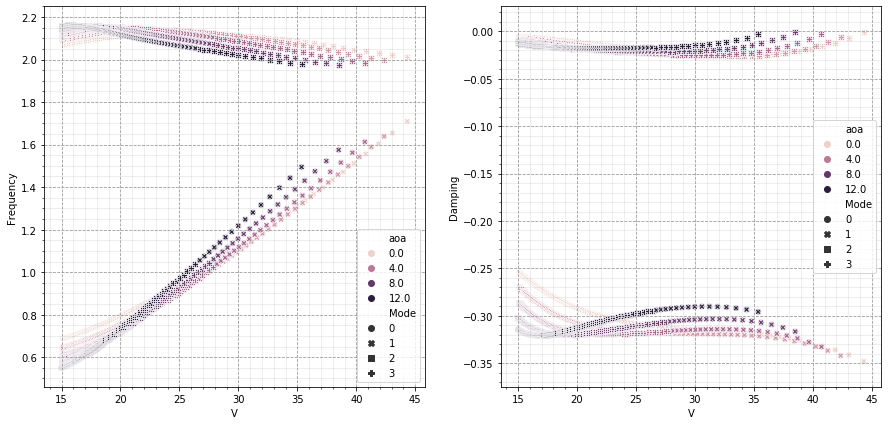

In [17]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
data = flutdfv2[(flutdfv2['Damping']<0)]
#data = flutdfv2
fig, axes = plt.subplots(1,2,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='aoa',style='Mode',ax=axes[0])
sns.scatterplot(data=data,x='V',y='Damping',hue='aoa',style='Mode',ax=axes[1])
for i in [0,1]:
    #axes[i].set(xlim=(0,80))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)